##### 2.1 Loading libraries and microbiome data #####

First, we start our R environment by loading the needed packages. For this, we need to install first Bioconductor and then the `phyloseq` library.

In [4]:
install.packages("BiocManager")
BiocManager::install("phyloseq")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'BiocVersion', 'phyloseq'

also installing the dependencies ‘bitops’, ‘Rhdf5lib’, ‘rhdf5filters’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘pixmap’, ‘sp’, ‘Rcpp’, ‘RcppArmadillo’, ‘rhdf5’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘GenomeInfoDb’, ‘iterators’, ‘permute’, ‘ade4’, ‘ape’, ‘Biobase’, ‘BiocGenerics’, ‘biomformat’, ‘Biostrings’, ‘foreach’, ‘igraph’, ‘multtest’, ‘plyr’, ‘reshape2’, ‘vegan’


Old packages: 'bit', 'curl', 'devtools', 'gargle', 'highr', 'isoband',
  'openssl', 'ragg', 'roxygen2', 'testthat', 'textshaping', 'whisker', 'boot'



Now we load our required libraries:

In [5]:
# load ggplot2 library (graphics)
library(ggplot2)

# loading phyloseq library (microbiome analysis)
library(phyloseq)

Then we load the needed input files: the OTU table (BIOM) and the metadata (TSV)

In [8]:
# OTU data
InputBiomFile <- "https://raw.githubusercontent.com/barrantesisrael/mbt.microbiome.2021/main/data2023/mbtmicrobiome2023.biom"

# Samples' metadata
InputMapFile <- "https://raw.githubusercontent.com/barrantesisrael/mbt.microbiome.2021/main/data2023/sample-metadata-2023.tsv"

# prepare phyloseq object by loading both files
BiomData <- import_biom(InputBiomFile, parseFunction = parse_taxonomy_greengenes)
SampleData <- import_qiime_sample_data(InputMapFile)

Afterwards, we merge these files into a single `phyloseq` object:

In [9]:
# create phyloseq object by merging OTU and sample data
ExperimentPhyloseqObject <- merge_phyloseq(BiomData, SampleData)

We call our object to see its properties:

In [10]:
# checking the features of our original microbiome data
ExperimentPhyloseqObject

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1012 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 1012 taxa by 7 taxonomic ranks ]

Now we create another phyloseq object, that includes only those taxa with more than 100 amplicons in all samples, and with `Gender` in the metadata

In [11]:
# create a temporary phyloseq object for working
psTemp <- ExperimentPhyloseqObject

# subset samples
# Prune OTUs with low abundances from all samples
psTemp <- prune_taxa(taxa_sums(psTemp) > 100, psTemp)

# Prune samples with no metadata
psTemp <-  subset_samples(psTemp, Gender != "NA")

# checking the features of our microbiome data
psTemp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 557 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 557 taxa by 7 taxonomic ranks ]

_Q: What are the differences between the `ExperimentPhyloseqObject` and `psTemp` objects?_

##### 2.2 Sample ordination #####

Warning message in decorana(veganifyOTU(physeq), ...):
“some species were removed because they were missing in the data”


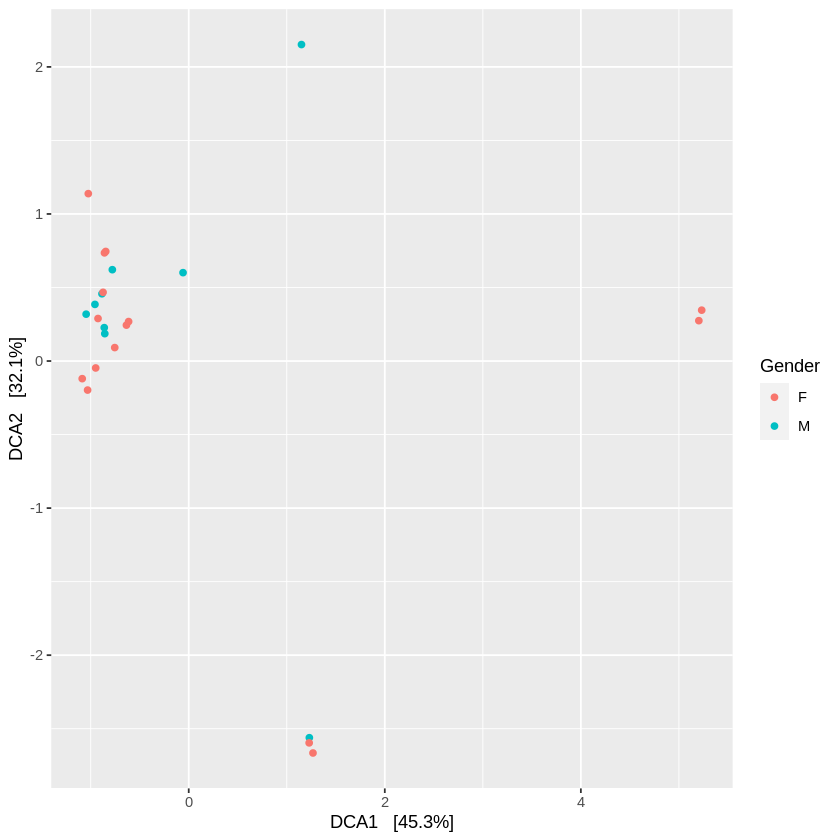

In [12]:
# Calculate distance and ordination
iDist <- distance(psTemp, method="bray")
iMDS  <- ordinate(psTemp, distance=iDist)

# plot sample ordination, e.g. by Gender
plot_ordination(psTemp, iMDS, color="Gender")

Q: Are there any clear separations between the gender groups? Why/Why not?

Repeat the ordination using other metada, e.g. "Cat":

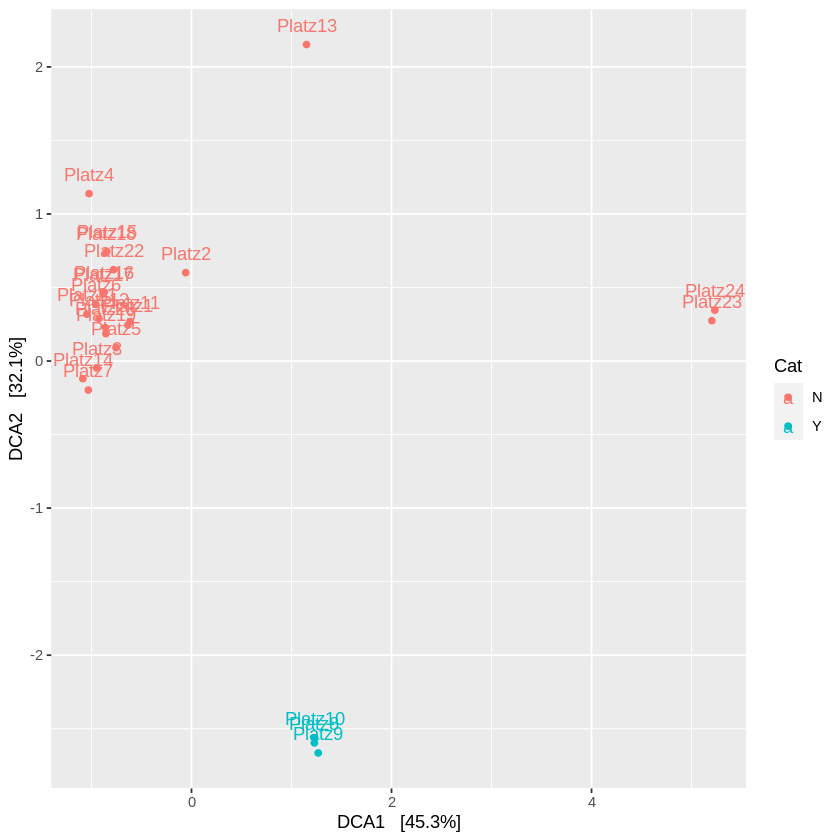

In [13]:
plot_ordination(psTemp, iMDS, color="Cat") +
  geom_text(aes(label=SampleID), vjust = -1)

##### 2.3 Microbial communities #####

First let's observe the absolute abundance on each sample at the Phylum level.

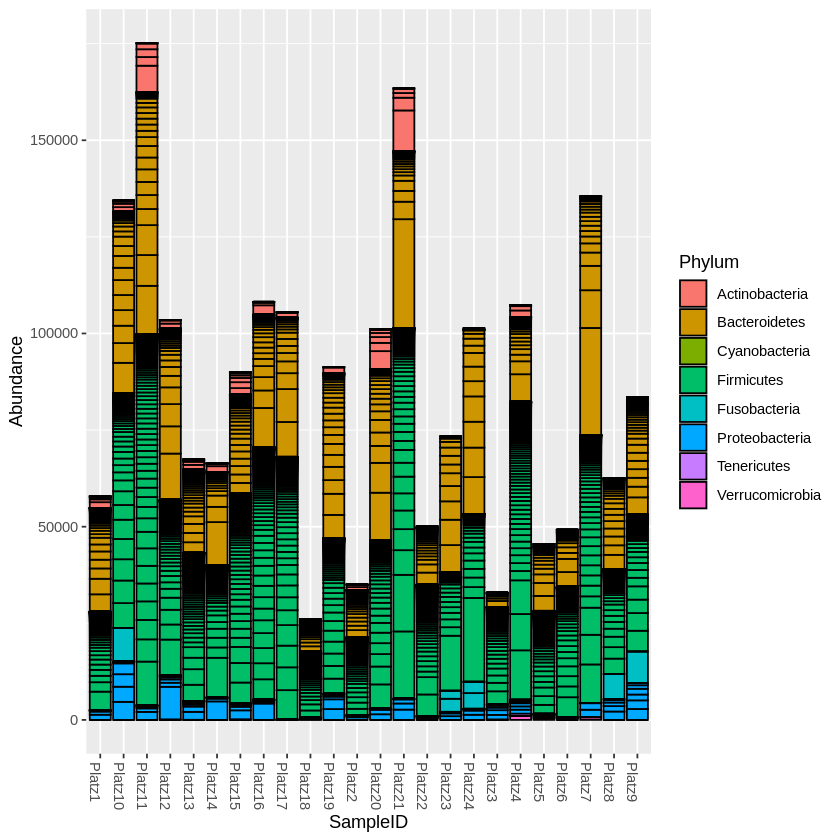

In [14]:
### Abundances per sample
plot_bar(psTemp, "SampleID", fill="Phylum")

As these are not directly comparable, we will perform a rarefaction, as a means to normalize the data, and then plot again

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

13OTUs were removed because they are no longer 
present in any sample after random subsampling


...



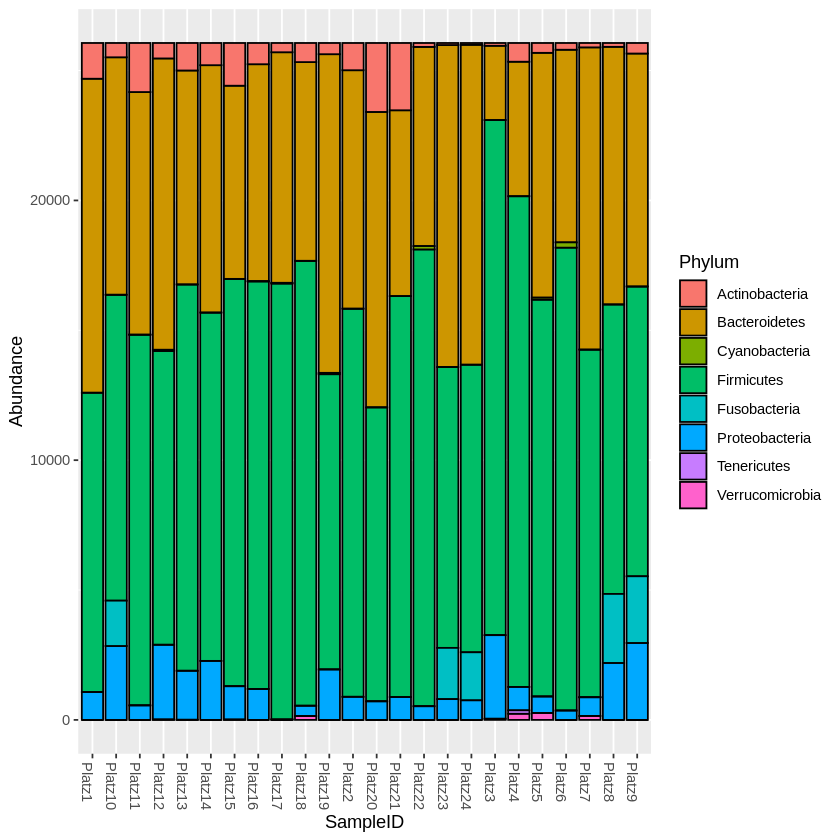

In [15]:
# Rarefaction to an even depth
ps.rarefied <- rarefy_even_depth(psTemp)

# Remove lines
ps.rarefied.glom <- tax_glom(ps.rarefied, "Phylum")

# Plot abundances
plot_bar(ps.rarefied.glom, "SampleID", fill="Phylum")

Q: _What are the differences between the abundance plots before and after rarefaction?_

We can also plot the relative abundances according to metadata, e.g. by `Gender`:

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

13OTUs were removed because they are no longer 
present in any sample after random subsampling


...



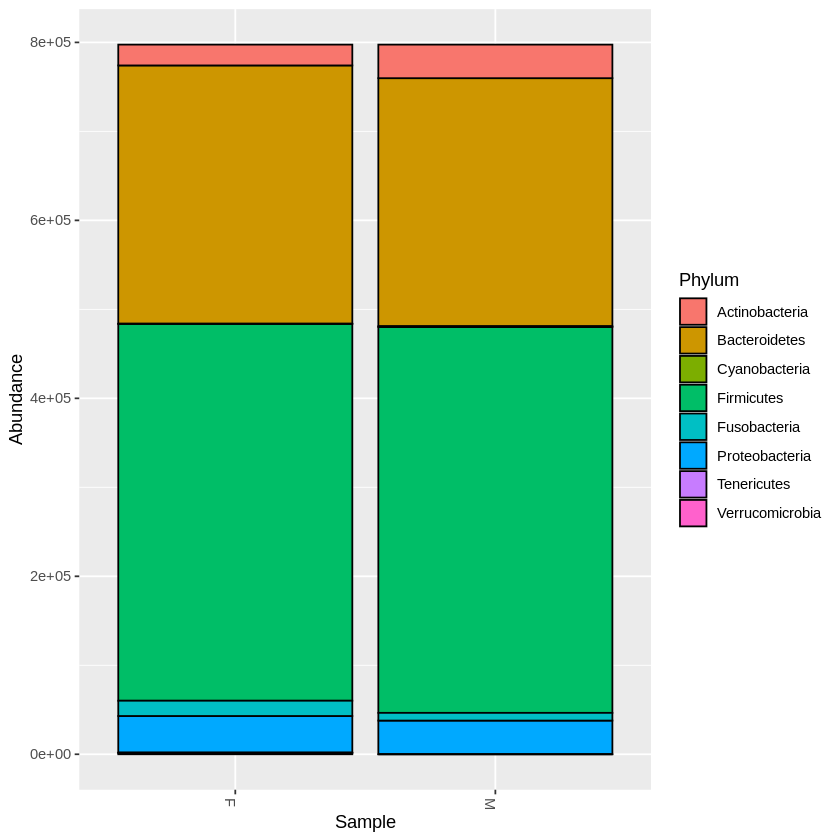

In [16]:
### Abundances per category, e.g. "Gender"
# Merge samples by the selected category
mergedGP <- merge_samples(psTemp, "Gender")

# Rarefaction to an even depth
ps.rarefied <- rarefy_even_depth(mergedGP)

# Remove lines
ps.rarefied.glom <- tax_glom(ps.rarefied, "Phylum")

# Plot abundances for the example category "Gender"
plot_bar(ps.rarefied.glom, fill="Phylum")

##### 2.4 Diversity #####

First let's observe the Shannon diversity on the individual samples:

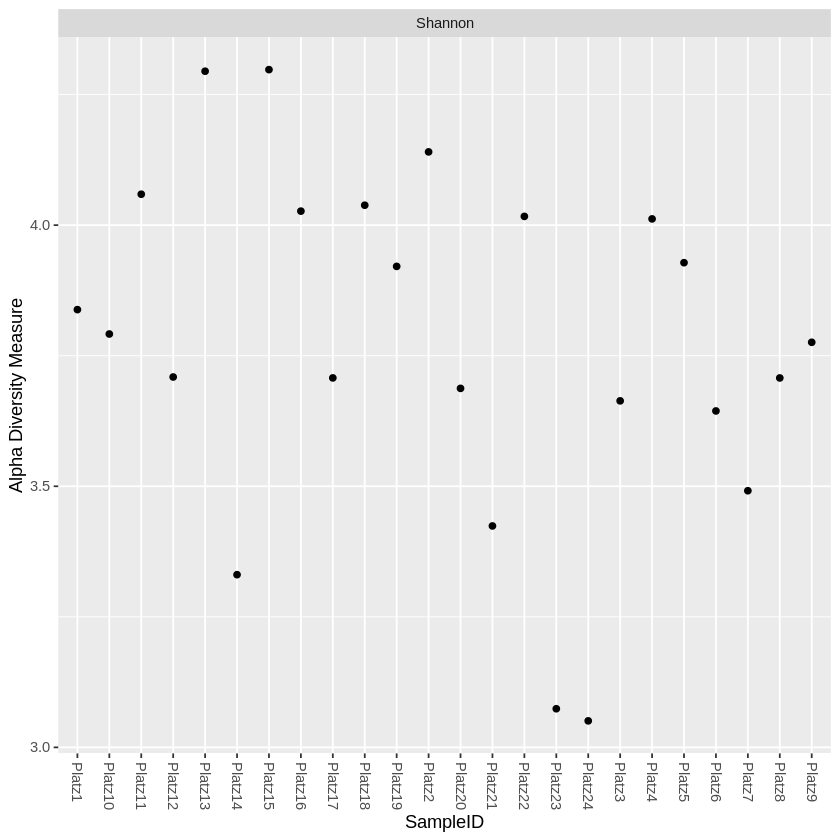

In [17]:
plot_richness(psTemp, x = "SampleID", measures = c("Shannon"))

 Repeat the same analyses at the Gender level:

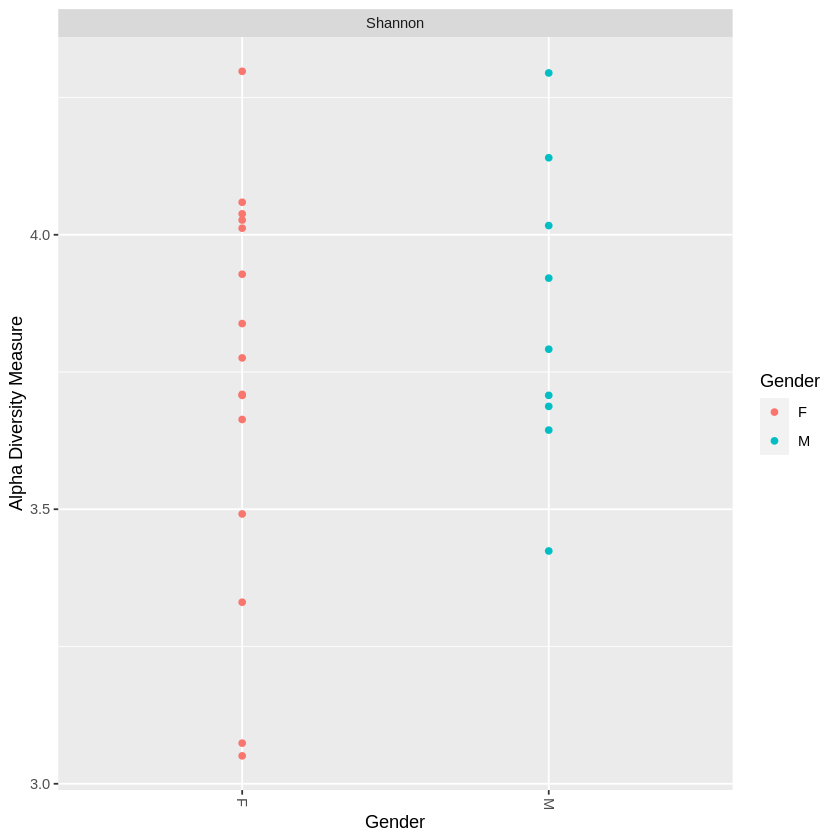

In [18]:
plot_richness(psTemp, x = "Gender", color = "Gender", measures = c("Shannon"))

A more appropriate view of our plot can be achieved by adding more features, e.g.:

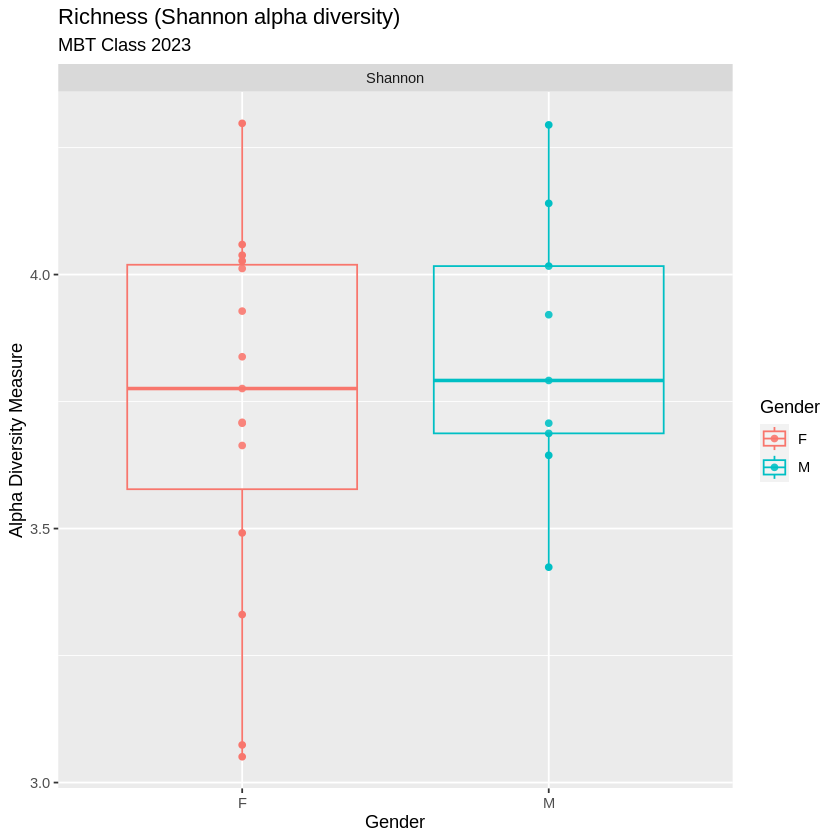

In [19]:
# Assign our plot to a variable
Our_Richness_plot <- plot_richness(psTemp, x = "Gender", color = "Gender", measures = c("Shannon"))

# Improving our plot e.g. by adding proper labels
Our_Richness_plot + geom_boxplot(data = Our_Richness_plot$data, aes(x = Gender, y = value, color = Gender), alpha = 0.1) + # boxplot
  labs(title = "Richness (Shannon alpha diversity)", subtitle = "MBT Class 2023") + # title and subtitle
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) # x-axis labels: 0 degree rotation, 0.5 horizontal position